**Lyrics Generation** : A machine learning model for generating song lyrics using neural network. This model leverages Bi-LSTM (Bidirectional Long Short-Term Memory) to create coherent and creative lyrics in various styles.


Text generation can be done through simply predicting the next most likely word, given an input sequence. This can be done over and over by feeding the original input sequence, plus the newly predicted end word, as the next input sequence to the model. As such, the full output generated from a very short original input can effectively go on however long you want it to be.

The only real change to the network here is the output layer will now be equivalent to a node per each possible new word to generate - so, if you have 1,000 possible words in your corpus, you’d have an output array of length 1,000. You’ll also need to change the loss function from binary cross-entropy to categorical cross entropy - before, we had only a 0 or 1 as output, now there are potentially thousands of output “classes” (each possible word).

**For text generation:**
- Predict the next word in the sequence
- Feed old input plus a new output word as the next input
- Make the output a one-hot encoded label over entire corpus of desired text outputs
- Utilize categorical cross entropy loss function as the output will be multi-class

The text generation model has the probabilities for all the words that can be the output and the word with the max probability is the one that completes the sequence.

In terms of modelling, there's not much of a difference in the network architecture except for changing the number of nodes in the output layer and changing the loss function.

The more obvious changes come in working with the input and output data. The input data takes chunks of sequences and just splits off the final word as its label.

So, if we had the sentence “I went to the beach with my dog”, and we had a max input length of five words, we’d get:

- Input: I went to the beach

- Label: with

Now, that’s not the only sequence that will come from the sentence! We would also get:

- Input: went to the beach with

- Label: my

And:

- Input: to the beach with my

- Label: dog

That’s how the N-Grams used in the pre-processing work - a single input sequence might actually become a series of sequences and labels.

#Simple Text Generation Model
(optimisation down below)

In [3]:
#Import Tf
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Other imports
import string
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv('songdata.csv')
print(df.head(10)) #first 10

  artist                   song                                        link  \
0   ABBA  Ahe's My Kind Of Girl  /a/abba/ahes+my+kind+of+girl_20598417.html   
1   ABBA       Andante, Andante       /a/abba/andante+andante_20002708.html   
2   ABBA         As Good As New        /a/abba/as+good+as+new_20003033.html   
3   ABBA                   Bang                  /a/abba/bang_20598415.html   
4   ABBA       Bang-A-Boomerang      /a/abba/bang+a+boomerang_20002668.html   
5   ABBA     Burning My Bridges    /a/abba/burning+my+bridges_20003011.html   
6   ABBA              Cassandra             /a/abba/cassandra_20002811.html   
7   ABBA             Chiquitita            /a/abba/chiquitita_20002978.html   
8   ABBA            Crazy World           /a/abba/crazy+world_20003013.html   
9   ABBA        Crying Over You       /a/abba/crying+over+you_20177611.html   

                                                text  
0  Look at her face, it's a wonderful face  \nAnd...  
1  Take it easy with

In [5]:
# Define preprocessing functions
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus

In [8]:
# Read the dataset from csv - just first 10 songs for now
dataset = pd.read_csv('songdata.csv', dtype=str)[:10]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus)

total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'you': 1, 'a': 2, 'i': 3, 'and': 4, 'me': 5, 'the': 6, 'is': 7, 'my': 8, 'to': 9, 'be': 10, 'ma': 11, 'it': 12, 'of': 13, "i'm": 14, 'your': 15, 'love': 16, 'so': 17, 'as': 18, 'boomerang': 19, 'that': 20, 'in': 21, 'andante': 22, 'boom': 23, 'make': 24, 'dumb': 25, 'on': 26, 'oh': 27, 'dum': 28, 'for': 29, 'but': 30, 'new': 31, 'bang': 32, "it's": 33, 'like': 34, 'know': 35, 'now': 36, 'how': 37, 'could': 38, "you're": 39, 'sing': 40, 'never': 41, 'no': 42, 'hum': 43, 'chiquitita': 44, 'can': 45, 'we': 46, 'song': 47, 'had': 48, 'good': 49, "you'll": 50, 'she': 51, 'just': 52, 'girl': 53, 'again': 54, 'will': 55, 'take': 56, 'please': 57, 'let': 58, 'am': 59, 'eyes': 60, 'was': 61, 'always': 62, 'cassandra': 63, 'blue': 64, 'time': 65, "don't": 66, 'were': 67, 'return': 68, 'once': 69, 'then': 70, 'sorry': 71, "cryin'": 72, 'over': 73, 'feel': 74, 'ever': 75, 'believe': 76, 'what': 77, 'do': 78, 'go': 79, 'all': 80, 'out': 81, 'think': 82, 'every': 83, 'leave': 84, 'look': 85, 'at': 

After preprocessing, we next need to create sequences and labels. Creating the sequences themselves is similar to before with texts_to_sequences, but also including the use of N-Grams; creating the labels will now utilize those sequences as well as utilize one-hot encoding over all potential output words.

In [9]:
#Create Sequences and Labels
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [10]:
# Check out how some of our data is being stored
# The Tokenizer has just a single index per word
print(tokenizer.word_index['know'])
print(tokenizer.word_index['feeling'])
# Input sequences will have multiple indexes
print(input_sequences[5])
print(input_sequences[6])
# And the one hot labels will be as long as the full spread of tokenized words
print(one_hot_labels[5])
print(one_hot_labels[6])

35
101
[  0   0   0   0   0   0   0   0   0   0   0   0   0  85  86 146 197  33
   2]
[  0   0   0   0   0   0   0   0   0   0   0   0  85  86 146 197  33   2
 285]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

Building an RNN to train our text generation model will be very similar to the sentiment models you've built previously. The only real change necessary is to make sure to use Categorical instead of Binary Cross Entropy as the loss function - we could use Binary before since the sentiment was only 0 or 1, but now there are hundreds of categories.

From there, we should also consider using more epochs than before, as text generation can take a little longer to converge than sentiment analysis, and we aren't working with all that much data yet. I'll set it at 200 epochs here since we're only use part of the dataset, and training will tail off quite a bit over that many epochs.

In [11]:
# Build the model and train it
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=200, verbose=1)

Epoch 1/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.0268 - loss: 6.1070
Epoch 2/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0318 - loss: 5.3926
Epoch 3/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0373 - loss: 5.3472
Epoch 4/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0480 - loss: 5.2541
Epoch 5/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0469 - loss: 5.1866
Epoch 6/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0418 - loss: 5.1298
Epoch 7/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0534 - loss: 5.0298
Epoch 8/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0439 - loss: 5.0044
Epoch 9/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0494 - loss: 4.8690
Epoch 10/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0664 - loss: 4.8656
Epoch 11/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0897 - loss: 4.8012
Epoch 12/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc

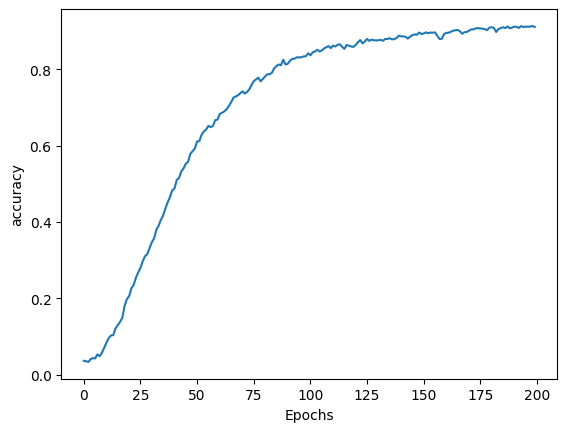

In [12]:
# Visualize training performance
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

It's finally time to generate some new lyrics from the trained model, and see what we get. To do so, we'll provide some "seed text", or an input sequence for the model to start with. We'll also decide just how long of an output sequence we want - this could essentially be infinite, as the input plus the previous output will be continuously fed in for a new output word (at least up to our max sequence length).

In [13]:
#Generate lyrics "just a model"
seed_text = "i am just a model"
next_words = 100

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

#Optimizing Models

**Options:**
1. Using More Data for Training
2. Improving Memory and Output size constraints
3. Using only top-k most common words
4. Adding to/subtracting from layer sizes or embedding dimensions
5. Using np.random.choice(opens in a new tab) with the probabilities for more variance in predicted outputs
6. Understanding your data well

Now we've seen a model trained on just a small sample of songs, and how this often leads to repetition as you get further along in trying to generate new text. Let's switch to using the 250 songs instead, and see if our output improves. This will actually be nearly 10K lines of lyrics, which should be sufficient.

Note that we won't use the full dataset here as it will take up quite a bit of RAM and processing time, but you're welcome to try doing so on your own later. If interested, you'll likely want to use only some of the more common words for the Tokenizer, which will help shrink processing time and memory needed (or else you'd have an output array hundreds of thousands of words long).

In [15]:
# Read the dataset from csv - this time with 250 songs
dataset = pd.read_csv('songdata.csv', dtype=str)[:250]

# Create a function to preprocess the lyrics
def preprocess_lyrics(dataset, field):
    # Remove punctuation
    dataset.loc[:, field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '', regex=True)
    # Convert to lowercase
    dataset.loc[:, field] = dataset[field].str.lower()

# Preprocess the 'text' column
preprocess_lyrics(dataset, 'text')

# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')

# Tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

# There should be a lot more words now
print(total_words)


2000


In [16]:
#Create sequences and labels
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [17]:
# Train a (Better) Text Generation Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64,))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.0444 - loss: 6.2242
Epoch 2/100
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.0485 - loss: 5.7186
Epoch 3/100
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.0569 - loss: 5.5180
Epoch 4/100
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.0851 - loss: 5.3220
Epoch 5/100
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.1146 - loss: 5.1292
Epoch 6/100
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.1290 - loss: 4.9454
Epoch 7/100
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.1505 - loss: 4.7786
Epoch 8/100
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.1618 - loss: 4.6214
Epoch 9/100
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.1801 - loss: 4.4638
Epoch 10/100
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.1940 - loss: 4.3451
Epoch 11/100
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.2035 - loss: 4.2226
Epoch 12

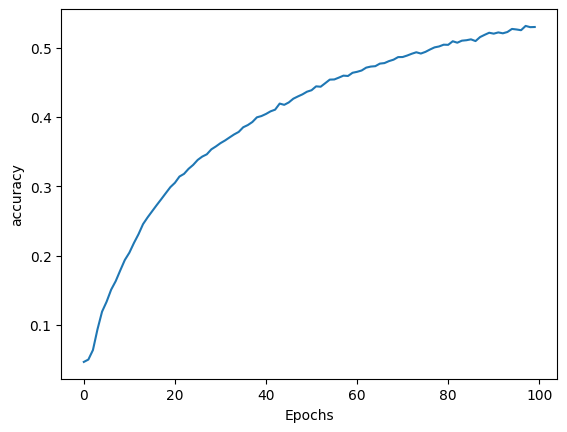

In [18]:
# Visualize training performance
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

In [19]:
# Generate Text

seed_text = "i am just a model"
next_words = 100

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In running the above, you may notice that the same seed text will generate similar outputs. This is because the code is currently always choosing the top predicted class as the next word. What if you wanted more variance in the output?

Switching from model.predict_classes to model.predict_proba will get us all of the class probabilities. We can combine this with np.random.choice to select a given predicted output based on a probability, thereby giving a bit more randomness to our outputs.

In [50]:
#Vary the outputs
# Test the method with just the first word after the seed text
seed_text = "i am just a model"
next_words = 100

token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))],
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1116


In [51]:
# Use this process for the full output generation
seed_text = "i am just a model"
next_words = 100

for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━